### IMPORTS

In [1]:
import torch
torch.manual_seed(0)
import torchvision
import numpy as np
import torchvision.models as models
from torch.autograd import Function
from torchvision import transforms
from IPython.display import display
import PIL
import ast
import cv2

from utils import preprocess_image, overlay_heatmap_on_image
from gradcam import GradCam

### TEST IMAGE

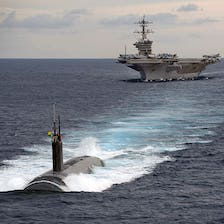

In [2]:
TEST_IMAGE = PIL.Image.open("./test_images/submarine_and_aircraft_carrier.jpg")
TEST_IMAGE_WIDTH = TEST_IMAGE.size[0]
TEST_IMAGE_HEIGHT = TEST_IMAGE.size[1]

display(TEST_IMAGE)
preprocessed_image = preprocess_image(TEST_IMAGE)

### MODEL

In [3]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### CLASSES

In [4]:
classes_file = open("imagenet_classes.txt", "r")
classes = ast.literal_eval(classes_file.read())
classes_file.close()
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### TOP 2 PREDICTION

In [5]:
output = model(preprocessed_image)
softmax = torch.softmax(output, dim=1)
top2 = torch.topk(softmax, 2)
print(top2)
# submarine ~95%, aircraft carrier ~5%

torch.return_types.topk(
values=tensor([[0.9504, 0.0472]], grad_fn=<TopkBackward>),
indices=tensor([[833, 403]]))


### GRADCAM

In [23]:
gradcam = GradCam(model=model, target_layer=model.layer4, target_layer_names=["1"])

In [24]:
def generate_cam_overlay_for_target_class(preprocessed_image, target_class=None):
    img = np.array(TEST_IMAGE) 
    img = img[:, :, ::-1].copy() 
    img = np.float32(img) / 255
    
    cam_heatmap = gradcam(preprocessed_image, target_class)
    cam_overlay = overlay_heatmap_on_image(img, cam_heatmap)
    return cam_overlay

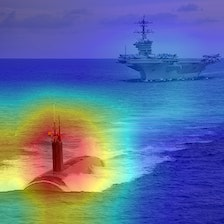

In [25]:
submarine_cam_overlay = generate_cam_overlay_for_target_class(preprocessed_image, 833)
display(PIL.Image.fromarray(cv2.cvtColor(submarine_cam_overlay, cv2.COLOR_BGR2RGB)))

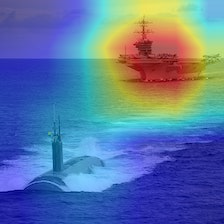

In [26]:
aircraft_carrier_cam_overlay = generate_cam_overlay_for_target_class(preprocessed_image, 403)
display(PIL.Image.fromarray(cv2.cvtColor(aircraft_carrier_cam_overlay, cv2.COLOR_BGR2RGB)))